### Generate data with the general dataset from VRS 
Format of general dataset
```
ucl_east/
    seq/
        000000.color.png
        000000.depth.png (mm)
        000000.semantic.png
    poses.txt (TUM format: timestamp tx ty tz qx qy qz qw)
    intrinsics.txt (format: fx fy cx cy width height)
```

#### Pipeline:
1. Load the VRS file
2. Load the MPS trajectory
3. Read through all images
4. For each image, find the nearest pose of the image, compute the pose of the camera, rotate image, and save
5. Save poses and intrinsics to files

In [7]:
import os
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
from projectaria_tools.core.mps.utils import get_nearest_pose
import projectaria_tools.core.mps as mps
from projectaria_tools.core.sophus import SO3, SE3, interpolate, iterativeMean
import numpy as np
import copy
from PIL import Image

from matplotlib import pyplot as plt
data_path = "/Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab"
# Input data
vrsfile = os.path.join(data_path, "ops_lab_vrs_3/ops_lab.vrs")
open_traj_file = os.path.join(data_path, "ops_lab_vrs_3/mps_ops_lab_vrs/slam/open_loop_trajectory.csv")
closed_traj_file = os.path.join(data_path, "ops_lab_vrs_3/mps_ops_lab_vrs/slam/closed_loop_trajectory.csv")
# Output data
out_dir = os.path.join(data_path, "out_general")
os.makedirs(out_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, "seq"), exist_ok=True)

In [8]:
# Load VRS file
provider = data_provider.create_vrs_data_provider(vrsfile)
assert provider is not None, "Cannot open file"
# Load trajectories
open_loop_traj = mps.read_open_loop_trajectory(open_traj_file)
closed_loop_traj = mps.read_closed_loop_trajectory(closed_traj_file)

Loaded #open loop trajectory poses records: 129850
Loaded #closed loop trajectory poses records: 129180


[ProgressLogger][INFO]: 2024-09-04 09:19:27: Opening /Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab/ops_lab_vrs_3/ops_lab.vrs...
[VRSIndexRecord][WARNING]: 11 record(s) not sorted properly. Sorting index.
[MultiRecordFileReader][DEBUG]: Opened file '/Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab/ops_lab_vrs_3/ops_lab.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 281-1/gps activated
[VrsDataProvider][INFO]: streamId 282-1/wps activated
[VrsDataProvider][INFO]: streamId 283-1/bluetooth activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][

(-0.5, 959.5, 539.5, -0.5)

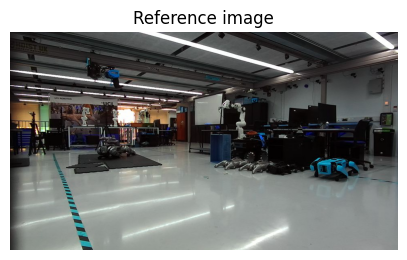

In [10]:
import cv2
image_path = os.path.join(data_path, "obs_image_example.png")
ref_img = cv2.imread(image_path)
ref_img_lab = cv2.cvtColor(ref_img, cv2.COLOR_BGR2LAB)
plt.figure(figsize=(5,5))
plt.imshow(ref_img, cmap='gray', vmin=0, vmax=255)
plt.title("Reference image")
plt.axis('off')

In [4]:
def reduce_image_domain_gap(tar_img, domain_unified_flag=False):
    if domain_unified_flag:
        import cv2
        import numpy as np
        from skimage import exposure

        tar_img_lab = cv2.cvtColor(tar_img, cv2.COLOR_BGR2LAB)
        tar_matched = np.empty_like(tar_img_lab)
        for i in range(3):
            tar_matched[:, :, i] = exposure.match_histograms(tar_img_lab[:, :, i], ref_img_lab[:, :, i])
        tar_matched_bgr = cv2.cvtColor(tar_matched, cv2.COLOR_LAB2BGR)
        return tar_matched_bgr
    else:
        return tar_img

In [9]:
flag_debug = False
# Initialize parameters
poses = np.zeros((0, 8))
intrinsics = np.zeros((0, 6))
img_save_idx = 0
# Set a initial pose
T_ini = SE3().from_matrix(np.eye(4, 4))
init_pose = False
# Load image
camera_label = "camera-rgb"
stream_id = provider.get_stream_id_from_label(camera_label)
num_data = provider.get_num_data(stream_id)
print(f"Stream ID (camera-rgb): {stream_id} with {num_data} data")
for index in range(0, num_data):
    img_data = provider.get_image_data_by_index(stream_id, index)
    img_timestamp = img_data[1].capture_timestamp_ns
    # print(f"Get image data at index {index} with timestamp {img_timestamp}")

    raw_calib = provider.get_device_calibration().get_camera_calib(camera_label)
    focal_length = raw_calib.get_focal_lengths()
    principal_point = raw_calib.get_principal_point()
    image_size = raw_calib.get_image_size() # width, height
    
    # pinhole = calibration.get_linear_camera_calibration(
    #     image_size[0], image_size[1], focal_length[0], camera_label, raw_calib.get_transform_device_camera())
    pinhole = calibration.get_linear_camera_calibration(
        576, 1024, focal_length[0] * (1024 / image_size[0]), camera_label, raw_calib.get_transform_device_camera()) # height, width
    raw_image = img_data[0].to_numpy_array()
    undistorted_image = calibration.distort_by_calibration(raw_image, pinhole, raw_calib)
    
    rotated_image = np.rot90(undistorted_image, k=3)
    pinhole_cw90 = calibration.rotate_camera_calib_cw90deg(pinhole)
    focal_length = pinhole_cw90.get_focal_lengths()
    principal_point = pinhole_cw90.get_principal_point()
    image_size = pinhole_cw90.get_image_size()

    if flag_debug:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 3, 1)
        plt.imshow(raw_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Raw image")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(undistorted_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Undistorted image")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(rotated_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Rotated image")
        plt.axis('off')
        plt.show()        

    pose_info = get_nearest_pose(closed_loop_traj, img_timestamp)
    if pose_info:
        T_world_device = pose_info.transform_world_device
        T_device_rgb_camera = pinhole_cw90.get_transform_device_camera()
        T_world_rgb_camera = T_world_device @ T_device_rgb_camera
        if not init_pose:
            # rotate the world frame to the gravity direction
            # T_gravity_camera = SE3().from_matrix3x4(np.array([0, 0, 1, 0, -1, 0, 0, 0, 0, -1, 0, 0]).reshape(3, 4))
            T_gravity_camera = SE3().from_matrix(np.eye(4, 4))

            # reset the camera pose at zero
            T_cam_reset = T_world_rgb_camera.inverse()

            # Compose the transformation
            T_offset = T_gravity_camera @ T_cam_reset
            
            init_pose = True
        T_world_rgb_camera_rgb_camera = T_offset @ T_world_rgb_camera

        vec = T_world_rgb_camera_rgb_camera.to_quat_and_translation()
        quat_wxyz, trans = vec[0, :4], vec[0, 4:]
        pose = np.array([img_timestamp/1e9, 
                         trans[0], trans[1], trans[2], 
                         quat_wxyz[1], quat_wxyz[2], quat_wxyz[3], quat_wxyz[0]])
        poses = np.vstack((poses, pose))
        intrinsic = np.array([focal_length[0], focal_length[1], 
                              principal_point[0], principal_point[1], 
                              image_size[0], image_size[1]])
        intrinsics = np.vstack((intrinsics, intrinsic))
        
        processed_img = reduce_image_domain_gap(rotated_image, domain_unified_flag=False)
        image_pil = Image.fromarray(processed_img.astype(np.uint8))
        image_pil.save(os.path.join(out_dir, "seq", f"{img_save_idx:06d}.color.jpg"))
        if img_save_idx % 100 == 0: print(f"Save image {img_save_idx:06d}.color.jpg")
        img_save_idx += 1

np.savetxt(os.path.join(out_dir, "poses.txt"), poses, fmt='%.9f')
np.savetxt(os.path.join(out_dir, "intrinsics.txt"), intrinsics, fmt='%.9f')

Stream ID (camera-rgb): 214-1 with 1955 data
Save image 000000.color.jpg
Save image 000100.color.jpg
Save image 000200.color.jpg
Save image 000300.color.jpg
Save image 000400.color.jpg
Save image 000500.color.jpg
Save image 000600.color.jpg
Save image 000700.color.jpg
Save image 000800.color.jpg
Save image 000900.color.jpg
Save image 001000.color.jpg
Save image 001100.color.jpg
Save image 001200.color.jpg
Save image 001300.color.jpg
Save image 001400.color.jpg
Save image 001500.color.jpg
Save image 001600.color.jpg
Save image 001700.color.jpg
Save image 001800.color.jpg
Save image 001900.color.jpg


### Visualize Poses

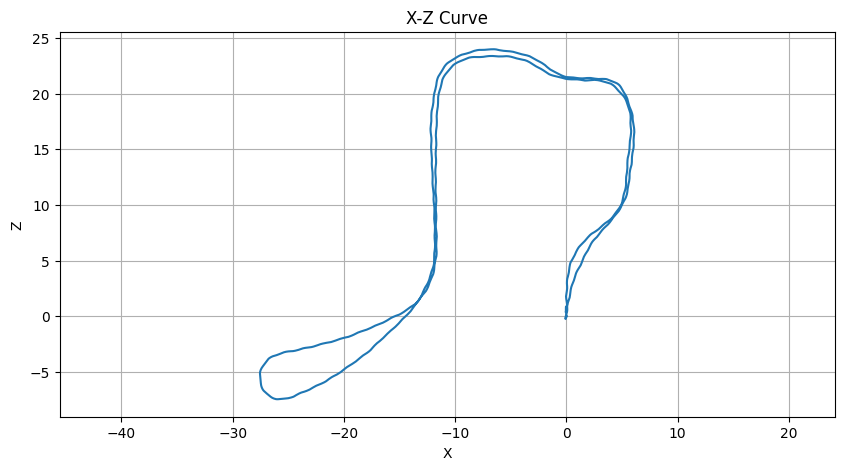

In [10]:

plt.figure(figsize=(10, 5))
plt.plot(poses[:, 1], poses[:, 3], '-')
plt.title('X-Z Curve')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')
plt.grid(True)
plt.show()